In [1]:
import numpy as np
import pandas as pd
from DS_Planck_Unet import load_planck_model
from DS_detector import gen_pics_for_detection, detect_clusters_connected
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
model = load_planck_model(
    '/home/rt2122/Models/planck_z/f8d2.ep0014-vl0.006570-l0.004067.hdf5')

In [3]:
thr = 0.1
steps = [64, 32, 16]
ep = 14

In [6]:
step_dict = {step : [] for step in steps}
for step in steps:
    for i in tqdm(range(48)):
        all_dict = gen_pics_for_detection(i, model, step=step)
        coords = detect_clusters_connected(all_dict, thr, i)
        step_dict[step].append(coords)

for step in steps:
    step_dict[step] = pd.concat(step_dict[step], ignore_index=True)
    step_dict[step].to_csv(
        '/home/rt2122/Data/scans_extended/connected/steps/ep{ep}_thr{thr}_step{step}.csv'.format(
            ep=ep, thr=thr, step=step), index=False)

/home/rt2122/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
step_dict = {}
for step in [8, 16, 32, 64]:
    step_dict[step] = pd.read_csv(
        '/home/rt2122/Data/scans_old/scans_extended/connected/steps/ep14_thr0.1_step{step}.csv'.\
        format(step=step))

In [4]:
set(step_dict[16]['status'])

{'fn', 'fp', 'tp'}

In [5]:
fp = []
recalls = {'planck_z' : [], 'planck_no_z' : [], 'mcxcwp' : [], 'act' : [], 'step' : []}
for step in step_dict:
    df = step_dict[step]
    fp.append(np.count_nonzero(df['status'] == 'fp'))
    recalls['step'].append(step)
    for cat in recalls:
        if cat == 'step':
            continue
        df = step_dict[step]
        df = df[df['catalog'] == cat]
        recalls[cat].append(np.count_nonzero(df['status'] == 'tp') / len(df))

In [6]:
fp[1] / fp[-1]

1.1327560294854362

In [7]:
recalls

{'planck_z': [0.9716636197440585,
  0.9643510054844607,
  0.9652650822669104,
  0.9579524680073126],
 'planck_no_z': [0.7567084078711985,
  0.7656529516994633,
  0.7280858676207513,
  0.6636851520572451],
 'mcxcwp': [0.1751886001676446,
  0.1751886001676446,
  0.16345347862531434,
  0.13914501257334452],
 'act': [0.11801075268817204,
  0.12043010752688173,
  0.1153225806451613,
  0.10403225806451613],
 'step': [8, 16, 32, 64]}

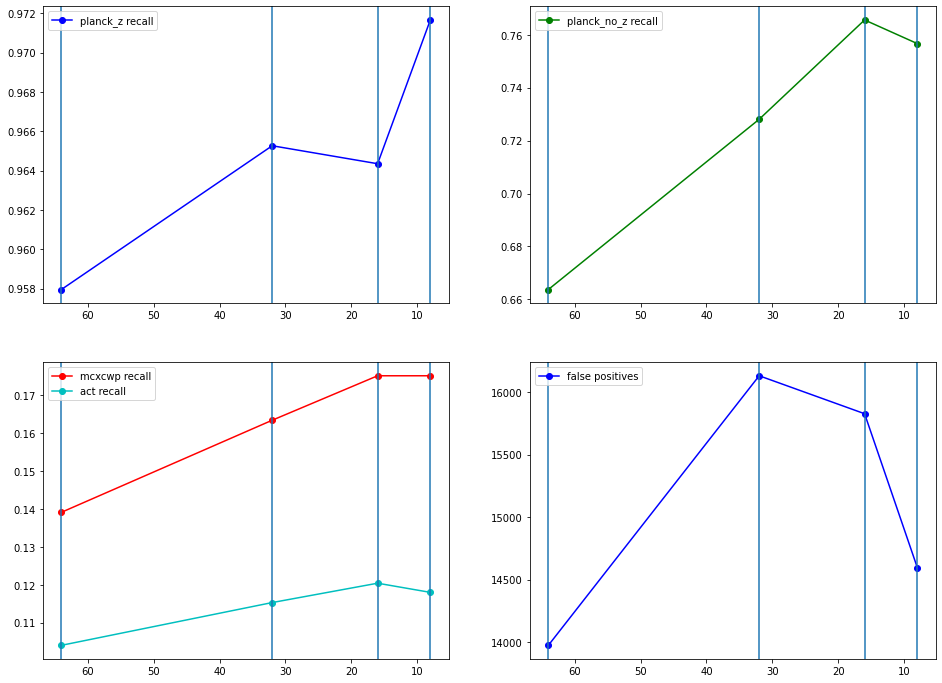

In [8]:
_, ax = plt.subplots(2, 2, figsize=(16, 12))
line, = ax[0][0].plot(recalls['step'], recalls['planck_z'], 'bo-')
line.set_label('planck_z recall')
line, = ax[0][1].plot(recalls['step'], recalls['planck_no_z'], 'go-')
line.set_label('planck_no_z recall')
line, = ax[1][0].plot(recalls['step'], recalls['mcxcwp'], 'ro-')
line.set_label('mcxcwp recall')
line, = ax[1][0].plot(recalls['step'], recalls['act'], 'co-')
line.set_label('act recall')
line, = ax[1][1].plot(recalls['step'], fp, 'bo-')
line.set_label('false positives')
for i in range(2):
    for j in range(2):
        ax[i][j].invert_xaxis()
        for step in recalls['step']:
            ax[i][j].axvline(step)
        ax[i][j].legend()

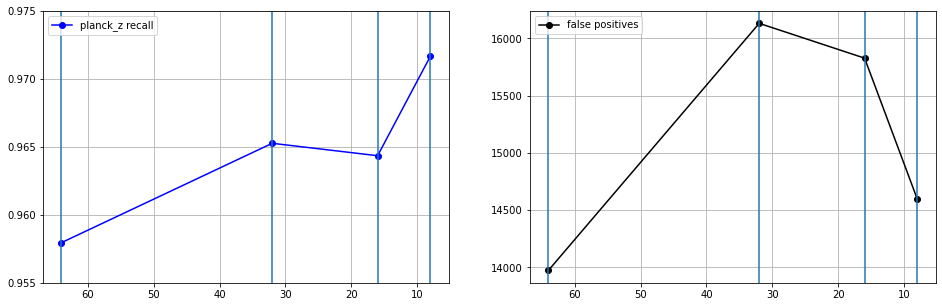

In [17]:
_, ax = plt.subplots(1, 2, figsize=(16, 5))
line, = ax[0].plot(recalls['step'], recalls['planck_z'], 'bo-')
line.set_label('planck_z recall')
line, = ax[1].plot(recalls['step'], fp, 'ko-')
line.set_label('false positives')
ax[0].set_yticks(np.arange(0.955, 0.975, 0.005))
for i in range(2):
    ax[i].invert_xaxis()
    ax[i].grid()
    for step in recalls['step']:
        ax[i].axvline(step)
    ax[i].legend()